<span style="font-size: 14pt">Простые алгоритмы машинного обучения, МФТИ, февраль 2018 </span>

<span style="color:blue; font-size: 12pt">Alexey Romanenko, </span>
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>
![](https://newapplift-production.s3.amazonaws.com/comfy/cms/files/files/000/001/201/original/machine-learning-robots-dilbert.gif)


<h1 align="center"> Данные </h1>


В этой работе мы научимся обучать модели машинного обучения, корректно ставить эксперименты, подбирать гиперпараметры, сравнивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
<img src='img/TaskDescription.PNG'>
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

In [1]:
import sys
print(sys.version)

import pandas as pd
import numpy as np
print("pandas version ", pd.__version__)

import sklearn
print("sklearn version", sklearn.__version__)

from sklearn.model_selection import train_test_split, GridSearchCV, KFold

from sklearn.tree import DecisionTreeClassifier
clf_dt = DecisionTreeClassifier()

from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier()

from sklearn.naive_bayes import GaussianNB
clf_nb = GaussianNB()

from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(random_state=241)

from sklearn import dummy

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

3.6.1 |Anaconda custom (64-bit)| (default, May 11 2017, 13:25:24) [MSC v.1900 64 bit (AMD64)]
pandas version  0.22.0
sklearn version 0.19.1


# Предобработка данных
Загрузите набор данных *data.adult.csv*. Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None)
columns = ('age workclass fnlwgt education educ-num marital-status occupation relationship ' 
           'race sex capital-gain capital-loss  hours-per-week native-country salary')
df.columns = columns.split()
df.head(5)

,age,workclass,fnlwgt,education,educ-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html). 

В данном датасете пропущенные значения обозначены как "?". 

**Задание** Найдите все признаки, имеющие пропущенные значения. Удалите из выборки все объекты с пропусками.

In [3]:
df.replace(' ?', np.nan, inplace=True)
df.count()

age               32561
workclass         30725
fnlwgt            32561
education         32561
educ-num          32561
marital-status    32561
occupation        30718
relationship      32561
race              32561
sex               32561
capital-gain      32561
capital-loss      32561
hours-per-week    32561
native-country    31978
salary            32561
dtype: int64

**Ответ:** Видим, что признаки workclass, occupation и native-country имеют пропуски. Удалим все объекты с пропусками из выборки

In [4]:
df = df.dropna()
df.count()

age               30162
workclass         30162
fnlwgt            30162
education         30162
educ-num          30162
marital-status    30162
occupation        30162
relationship      30162
race              30162
sex               30162
capital-gain      30162
capital-loss      30162
hours-per-week    30162
native-country    30162
salary            30162
dtype: int64

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 

 - Выделите целевую переменную (ту, которую мы хотим предсказывать) в отдельную переменную, удалите ее из датасета и преобразуйте к бинарному формату.
 - Обратите внимание, что не все признаки являются вещественными (числовыми). В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [5]:
df_prc = df.copy()
df_prc['salary'] = df['salary'].apply((lambda x: x==' >50K'))
X = df_prc[df._get_numeric_data().columns]
y = np.array(df_prc['salary'], dtype='int')
X.head(5)

,age,fnlwgt,educ-num,capital-gain,capital-loss,hours-per-week
0,39,77516,13,2174,0,40
1,50,83311,13,0,0,13
2,38,215646,9,0,0,40
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40


# Разбиение на обучение и контроль 
** Вопрос** 
* Зачем нужно разбиение на обучение и контроль?
<img src='img/CV.JPG', width=600>

## Разовое разбиение данных на обучение и контроль (hold-out)
<img src = 'img/TrainValidate.png'>

In [57]:
X_train, X_test, y_train, y_test = train_test_split(np.asarray(X), y, test_size = 0.3)

In [31]:
#убедимся, что тестовая выборка действительно составляет 0.3 от всех данных
float(len(test_labels))/len(y)

0.3000132617200451

## Стратегии проведения кросс-валидации

## KFold
<img src='img/k-fold.png'>

In [13]:
X_example=list(range(10))
kf = KFold(n_splits=2)

for train_indices, test_indices in kf.split(X_example):
    print (train_indices, test_indices)

[5 6 7 8 9] [0 1 2 3 4]
[0 1 2 3 4] [5 6 7 8 9]


In [14]:
#многократный запуск приводит к различным разбиениям
kf = KFold(n_splits=2,  shuffle=True)

for train_indices, test_indices in kf.split(X_example):
    print (train_indices, test_indices)

[0 1 2 5 7] [3 4 6 8 9]
[3 4 6 8 9] [0 1 2 5 7]


In [19]:
#многократный запуск приводит к одному и  тому же разбиению, результат запуска детерминированный
kf = KFold(n_splits=2,  shuffle=True, random_state=1)

for train_indices, test_indices in kf.split(X_example):
    print (train_indices, test_indices)

[1 3 5 7 8] [0 2 4 6 9]
[0 2 4 6 9] [1 3 5 7 8]


<h1 align="center"> Модели для классификации </h1>
Сейчас и далее будем рассматривать 4 алгоритма:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
 - [Naive Bayes](http://scikit-learn.org/stable/modules/naive_bayes.html)

Для начала разберём параметры каждого из алгоритмов
# kNN: K Near Neighbours (k ближайших соседей)

Одна из самых простых идей -- взять класс наиболее близких (похожих объектов) к объекту $u$.

<img src='img/knn-concept.png', Width=600>

Выразим эту идею в виде формулы.

## $$a(u, X^l) = \arg \max_{y \in Y} \sum_{i=1}^{k} [y^{(i)} = y]$$
### $(x^{(i)}, y^{(i)})$ - $i$-й сосед объекта $u$ относительно некоторой метрики

Выберем случайный не очень хороший объект, и посмотрим на 10 ближайших соседей

In [33]:
example_id = 40
clf_knn = KNeighborsClassifier().fit(X_train, y_train)
distances, indices =clf_knn.kneighbors(X_train[example_id].reshape(1,-1), n_neighbors=11)
pd.DataFrame.from_dict({'distances':distances[0], 'indices': indices[0], 'labels':y_train[indices][0]})

,distances,indices,labels
0,0.000000,40,0
1,26.795522,13751,0
2,121.564798,45,0
3,122.437739,14922,0
4,157.165518,15042,0
5,160.427554,17596,1
6,160.567743,16994,0
7,177.513380,14979,1
8,191.577660,5018,0
9,191.702895,9496,0


## Метрики расстояния для kNN

** Вопросы **
* Почему Евклидова метрика не всегда подходит?
  - Простым примером является классификация пола человека по зарплате и росту --- зарплата измеряется в тысячах рублей а рост в метрах, но при использовании эвклидовой метрики разница в 1 рубль в зарплате будет эквивалентна разнице в 1 метр в росте человека. Тогда расстояние между людьми будет определяться исключительно зарплатой, а пост будет играть роль только при условии равны зарплат.

* Какие вы знаете другие метрики (расстояния)?
 - Минковского
     - Хемминга
     - Чебышева
 - Косинусная

In [55]:
from scipy.spatial.distance import cosine, euclidean, minkowski
x_exampe = X_test[10]

### Minkowski Distance

### $$\rho(x, x_i) = \left(\sum_{j} w_j \cdot |f_j(x) - f_j(x_i)| ^p \right) ^ {\frac{1}{p}}$$

### $w_i$ - веса признаков (нормировка),$~f_j$ - возможно, нелинейное преобразование

<img src='img/1.png'>
<img src='img/3.png'>
<img src='img/2.png'>

## DT: DecisonTree (Деревья решений)
<img src='img/DT_example.png'>

** Вопрос: **
* Какие параметры есть у DT?

In [34]:
clf_dt = DecisionTreeClassifier().fit(X_train, y_train)
clf_dt

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

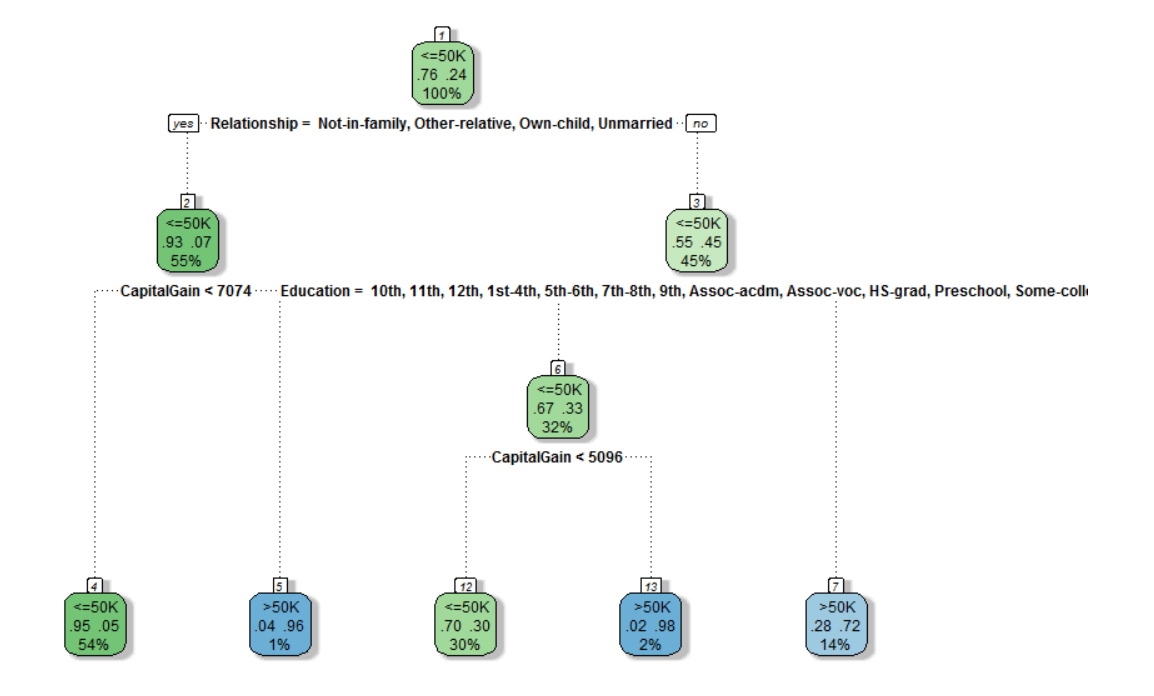

In [35]:
# Нарисуем дерево
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(clf_dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png()) # ВНИМАНИЕ: тут требуется предустановленный GraphViz 
Image("img/AdultDT.png")

## RF: Random Foreast (Случайный лес)
<img src = 'img/RF_example.png'>

In [51]:
clf_rf = RandomForestClassifier().fit(X_train, y_train)
clf_rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

** Вопрос: **
* Какие параметры есть у RF?

## NB: Naive Bayes (Наивный байес)

* Требуется знание частоты значений классов
<img src='img/NB_exampl.jpg'>

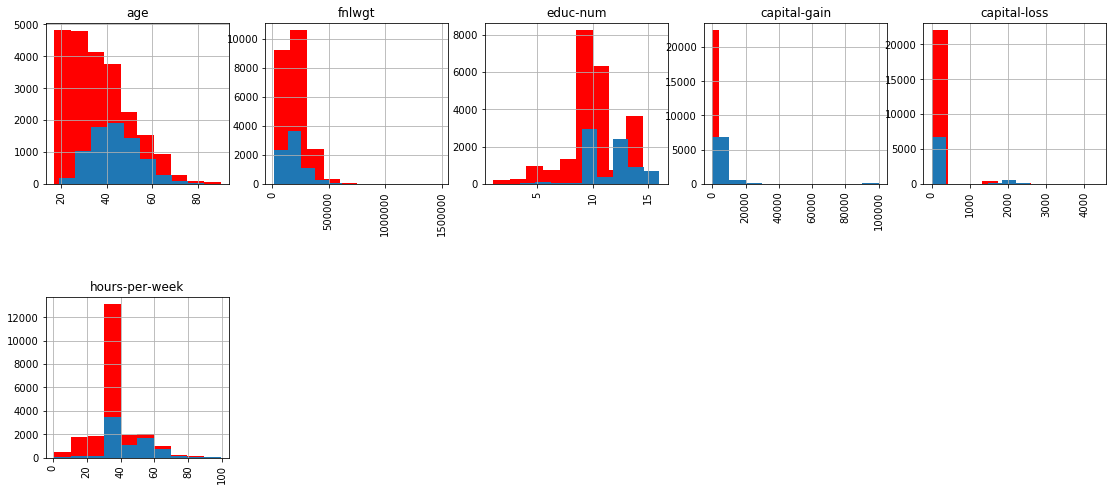

In [76]:
fig = plt.figure(figsize=(19,8))
cols = 5
rows = np.ceil( X.shape[1] / cols)
for i, column in enumerate(X.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    X.loc[df_prc['salary']==False, column].hist(axes=ax, color='red')
    X.loc[df_prc['salary']==True, column].hist(axes=ax)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [40]:
clf_nb = GaussianNB().fit(X_train, y_train)
clf_nb

GaussianNB(priors=None)

** Вопрос: **
* Какие параметры есть у NB?

<h1 align="center"> Обучение алгоритмов (настройка гиперпараметров) </h1>
В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки.


**Задание** Для каждого алгоритма подберите оптимальные значения указанных гиперпараметров. Постройте график среднего качества по кросс-валидации алгоритма при заданном значении гиперпараметра.

# Как измерять ошибку классификации


** Вопрос **
* Какую взять метрику?

Возьмём 2 классификаторва 
- умный kNN
- глупый -- DummyClassifier (самый популярный класс)

In [59]:
knn = KNeighborsClassifier().fit(X_train, y_train)
clf_mp = dummy.DummyClassifier("most_frequent").fit(X_train, y_train)

In [60]:
y_knn = knn.predict(X_test)
y_mp = clf_mp.predict(X_test)

In [61]:
y_knn

array([0, 0, 1, ..., 0, 0, 0])

In [62]:
y_mp

array([0, 0, 0, ..., 0, 0, 0])

In [63]:
y_test

array([0, 1, 0, ..., 1, 0, 1])

### $$Accuracy = \frac{\sum_{x_i, y_i \in (X, Y)} I(y(x_i) = y_i)}{|(X, Y)|} = \frac{num~right~classified~obj}{num~all~obj}$$

In [64]:
print ('knn =', sklearn.metrics.accuracy_score(y_test, y_knn), 'mp =', sklearn.metrics.accuracy_score(y_test, y_mp))

knn = 0.767377610786 mp = 0.751685269091


** Вопросы **
* На самом ли деле kNN выдает настолько плох?
* Какую использовать метрику точности предсказаний при несбалансированных классах?

## Модельный пример
<img src='img/PR_RC_1.png'>
<img src='img/PR_RC_2.png'>
<img src='img/PR_RC_3.png'>
<img src='img/PR_RC_4.png'>

### Матрица ошибок

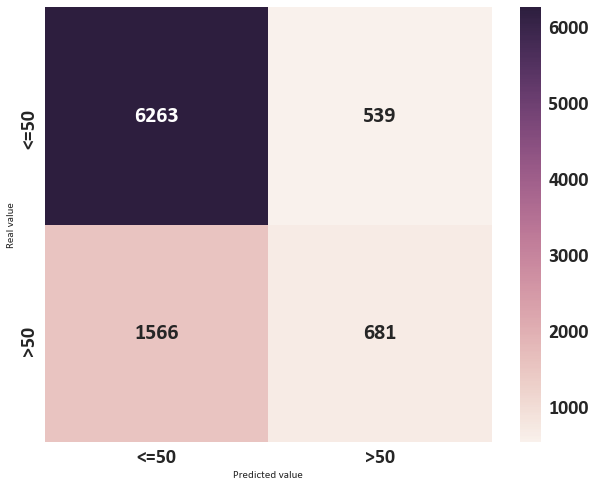

In [71]:
fig = plt.figure(figsize=(10,8))
nn_mtx = sklearn.metrics.confusion_matrix(y_test, y_knn)

font = {'family' : 'Calibri', 'weight' : 'bold', 'size'   :22}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
sns.heatmap(nn_mtx, annot=True, fmt="d", 
            xticklabels=["<=50", '>50'], 
            yticklabels=["<=50", '>50'])
plt.ylabel("Real value")
plt.xlabel("Predicted value")

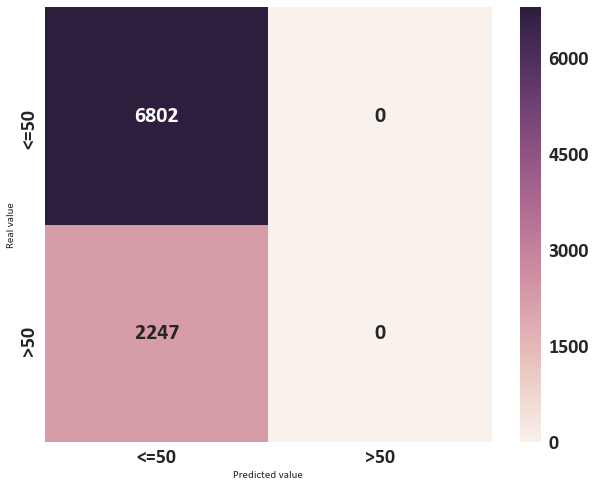

In [77]:
mp_mtx = sklearn.metrics.confusion_matrix(y_test, y_mp)

font = {'family' : 'Calibri', 'weight' : 'bold', 'size'   :22}
matplotlib.rc('font', **font)
fig = plt.figure(figsize=(10,8))
sns.heatmap(mp_mtx, annot=True, fmt="d", 
            xticklabels=["<=50", '>50'], 
            yticklabels=["<=50", '>50'])
plt.ylabel("Real value")
plt.xlabel("Predicted value")

### Precision

## $$Precision = \frac{TP}{TP + FP}$$

In [75]:
print ('knn =', sklearn.metrics.precision_score(y_test, y_knn), 'mp =', sklearn.metrics.precision_score(y_test, y_mp))

knn = 0.558196721311 mp = 0.0


C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


** Вопрос: **
* Приведите пример работы классификатора когда precition большой а классификатор работает плохо?

### Recall

## $$Recall = \frac{TP}{TP + FN}$$

In [76]:
print ('knn =', sklearn.metrics.recall_score(y_test, y_knn), 'mp =', sklearn.metrics.recall_score(y_test, y_mp))

knn = 0.303070761015 mp = 0.0


** Вопрос: ** 
* Приведите пример работы классификатора когда recall большой а классификатор работает плохо?

### AUC-ROC

In [80]:
clf_knn = neighbors.KNeighborsClassifier(n_neighbors=29).fit(X_train, y_tain)
clf_mp = dummy.DummyClassifier("most_frequent").fit(X_train, y_tain)

In [81]:
y_knn = clf_knn.predict(X_test)
y_mp = clf_mp.predict(X_test)

ROC AUC = 0.5802


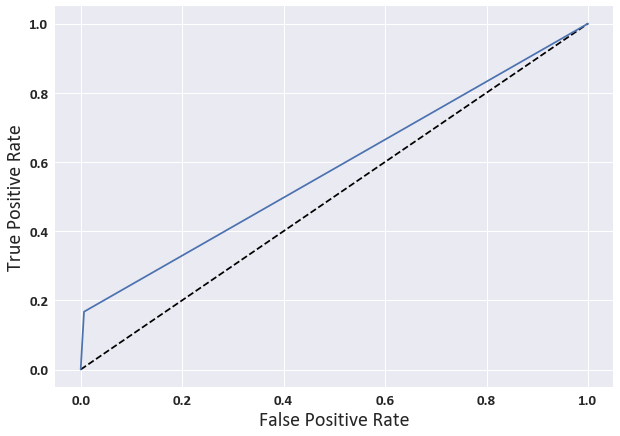

In [90]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_knn)
pylab.figure(figsize=(10, 7))
pylab.plot([0, 1], [0, 1], 'k--')
pylab.plot(fpr, tpr)
print ('ROC AUC = {0:.4f}'.format(metrics.auc(fpr, tpr)))
plt.ylabel("True Positive Rate", fontsize=20)
plt.xlabel("False Positive Rate", fontsize=20)

ROC AUC = 0.5000


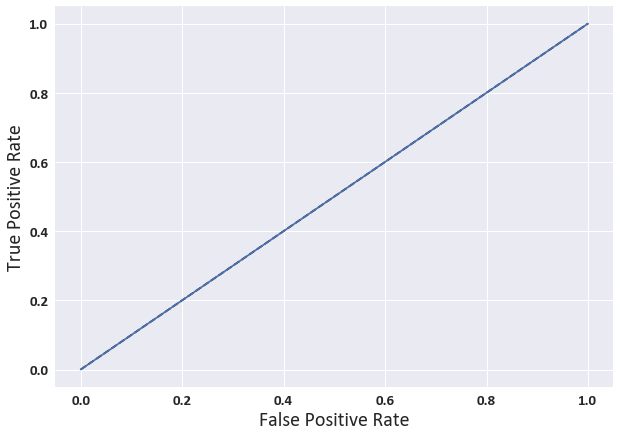

In [89]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_mp)
pylab.figure(figsize=(10, 7))
pylab.plot([0, 1], [0, 1], 'k--')
pylab.plot(fpr, tpr)
print ('ROC AUC = {0:.4f}'.format(metrics.auc(fpr, tpr)))
plt.ylabel("True Positive Rate", fontsize=20)
plt.xlabel("False Positive Rate", fontsize=20)

** Вопрос **
* Когда AUC большой при плохой работе классификатора?

# Обучение моделей (настройка гиперпараметров) на вещственных признаков

In [78]:
def grid_plot(x, y, x_label, title, y_label='roc_auc'):
    plt.figure(figsize=(12, 6))
    plt.grid(True)
    plt.plot(x, y, 'go-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

### Подбор параметра n_neighbors для KNeighborsClassifier

In [86]:
knn_grid = {'n_neighbors': np.array(np.linspace(1, 200, 20), dtype='int')}
gs = GridSearchCV(clf_knn, knn_grid, scoring='roc_auc', cv=5, n_jobs=5)
gs.fit(X, y)
gs.best_params_, gs.best_score_

({'n_neighbors': 11}, 0.65360144160751299)

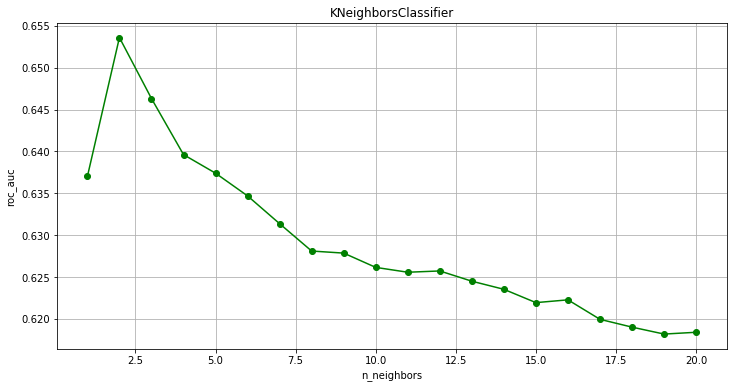

In [87]:
grid_plot(knn_grid['n_neighbors'], gs.cv_results_['mean_test_score'], 'n_neighbors', 'KNeighborsClassifier')

In [89]:
knn_grid = {'n_neighbors': np.array(np.linspace(1, 20, 20), dtype='int')}
gs = GridSearchCV(clf_knn, knn_grid, scoring='roc_auc', cv=10, n_jobs=5)
gs.fit(X, y)
gs.best_params_, gs.best_score_

({'n_neighbors': 4}, 0.67244166245857218)

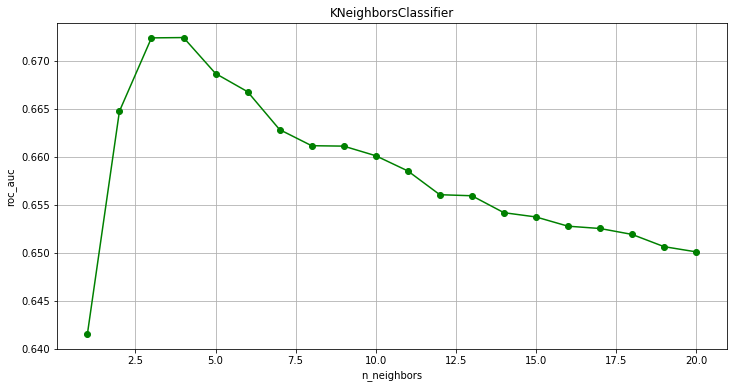

In [90]:
grid_plot(knn_grid['n_neighbors'], gs.cv_results_['mean_test_score'], 'n_neighbors', 'KNeighborsClassifier')

### Подбор параметра max_depth для DecisionTreeClassifier

In [92]:
decision_tree_grid = {'max_depth': np.array(np.linspace(1, 500, 100), dtype='int')}
gs = GridSearchCV(clf_dt, decision_tree_grid, scoring='roc_auc', cv=5, n_jobs=5)
gs.fit(X, y)
gs.best_params_, gs.best_score_

({'max_depth': 6}, 0.84031115987343796)

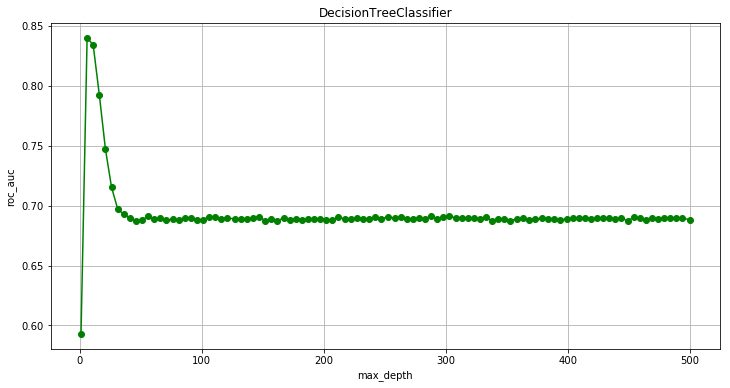

In [93]:
grid_plot(decision_tree_grid['max_depth'],  gs.cv_results_['mean_test_score'], 'max_depth', 'DecisionTreeClassifier')

In [94]:
decision_tree_grid = {'max_depth': np.array(np.linspace(1, 21, 20), dtype='int')}
gs = GridSearchCV(clf_dt, decision_tree_grid, scoring='roc_auc', cv=5, n_jobs=5)
gs.fit(X, y)
gs.best_params_, gs.best_score_

({'max_depth': 8}, 0.84670456073910749)

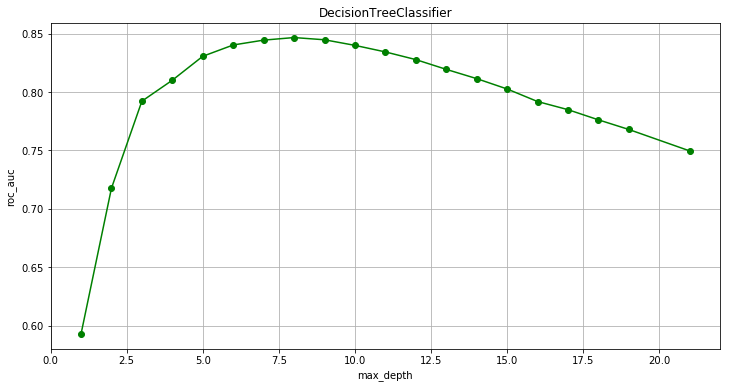

In [95]:
grid_plot(decision_tree_grid['max_depth'], gs.cv_results_['mean_test_score'], 'max_depth', 'DecisionTreeClassifier')

### Подбор параметра n_estimators для RandomForestClassifier

In [97]:
random_forest_grid = {'n_estimators': np.linspace(100, 1000, 10, dtype='int')}
gs = GridSearchCV(clf_rf, random_forest_grid , scoring='roc_auc', cv=5, n_jobs=5)
gs.fit(X, y)
gs.best_params_, gs.best_score_

({'n_estimators': 900}, 0.82404805778285528)

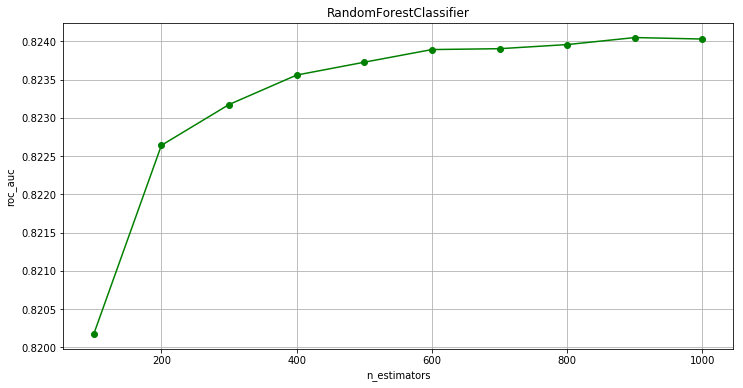

In [98]:
grid_plot(random_forest_grid['n_estimators'],  gs.cv_results_['mean_test_score'], 'n_estimators', 'RandomForestClassifier')

In [52]:
random_forest_grid = {'n_estimators': np.linspace(800, 1000, 10, dtype='int')}
gs = GridSearchCV(clf_rf, random_forest_grid, scoring='roc_auc', cv=5, n_jobs=5)
gs.fit(X, y)
gs.best_params_, gs.best_score_

({'n_estimators': 888}, 0.82404823076483014)

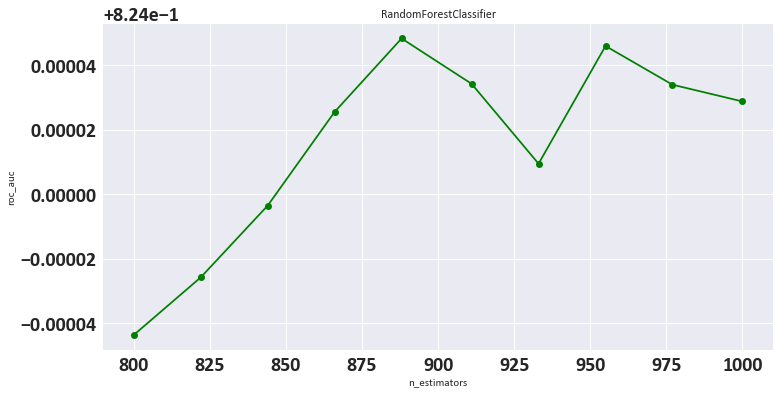

In [79]:
grid_plot(random_forest_grid['n_estimators'],  gs.cv_results_['mean_test_score'], 'n_estimators', 'RandomForestClassifier')

### Обучение NaiveBayesClassifier

In [42]:
random_forest_grid = {}
gs = GridSearchCV(clf_nb, random_forest_grid, scoring='roc_auc', cv=10, n_jobs=5)
gs.fit(X, y)
gs.best_params_, gs.best_score_

({}, 0.81835101128577803)

------------------------
## Масштабирование признаков 
Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака
 
** Вопрос **
* Для каких моделей масштабирование признаков должно привести к изменению точности классификации?
 
**Задание** Масштабируйте все вещественные признаки одним из указанных способов и подберите оптимальные значения гиперпараметров аналогичо пункту выше.

In [44]:
from sklearn.preprocessing import scale
X_scaled = scale(np.array(X, dtype='float'))

### Подборка параметра n_neighbors для KNeighborsClassifier при нормированных признаках

In [48]:
grid = {'n_neighbors': np.array(np.linspace(1, 100, 10), dtype='int')}
gs = GridSearchCV(clf_knn, grid, scoring='roc_auc', cv=5, n_jobs=5)
gs.fit(X_scaled, y)
gs.best_params_, gs.best_score_

({'n_neighbors': 78}, 0.83967542484706326)

In [49]:
grid = {'n_neighbors': np.array(np.linspace(71, 89, 10), dtype='int')}
gs = GridSearchCV(clf_knn, grid, scoring='roc_auc', cv=5, n_jobs=5)
gs.fit(X_scaled, y)
gs.best_params_, gs.best_score_

({'n_neighbors': 71}, 0.83964515116216609)

### Подборка параметра max_depth для DecisionTreeClassifier при нормированных признаках

In [111]:
grid = {'max_depth': np.array(np.linspace(1, 200, 10), dtype='int')}
gs = GridSearchCV(clf_dt, grid, scoring='roc_auc', cv=5, n_jobs=5)
gs.fit(X_scaled, y)
gs.best_params_, gs.best_score_

({'max_depth': 11}, 0.81479976763095474)

In [112]:
grid = {'max_depth': np.array(np.linspace(5, 20, 15), dtype='int')}
gs = GridSearchCV(clf_dt, grid, scoring='roc_auc', cv=5, n_jobs=5)
gs.fit(X_scaled, y)
gs.best_params_, gs.best_score_

({'max_depth': 10}, 0.81549127953624745)

### Подор параметра n_estimators для RandomForestClassifier

In [51]:
grid = {'n_estimators': np.linspace(100, 1000, 10, dtype='int')}
gs = GridSearchCV(clf_rf, grid, scoring='roc_auc', cv=5, n_jobs=5)
gs.fit(X_scaled, y)
gs.best_params_, gs.best_score_

({'n_estimators': 900}, 0.82397993363379052)

## Обучение Naive Bayes

In [45]:
nb_grid = {}
gs = GridSearchCV(clf_nb, nb_grid, scoring='roc_auc', cv=10, n_jobs=5)
gs.fit(X_scaled, y)
gs.best_params_, gs.best_score_

({}, 0.82670632315835524)

Изменилось ли качество у некоторых алгоритмов?

Посмотрим следующую таблицу

In [47]:
pd.DataFrame([['KNN', 'n_neighbors', 4, 71, 0.6724, 0.8397],
             ['Decision Tree', 'max depth', 8, 71,  0.8467, 0.8396],
             ['Random Forest', 'n_estimators', 888, 900, 0.8240, 0.8240],
             ['Naive Bayes', '', '-', '-', 0.8184, 0.8267]],
             columns=['clf', 'param', 'best param', 'best scaled param', 'score', 'scaled score'])

,clf,param,best param,best scaled param,score,scaled score
0,KNN,n_neighbors,4,81,0.6724,0.8001
1,Decision Tree,max depth,8,10,0.8467,0.8455
2,Random Forest,n_estimators,900,91,0.8240,0.8240
3,Naive Bayes,,-,-,0.8184,0.8267


Как видим, что нормализация признаков в данном случае не улучшает, а ухудшает качество классификации. В случае Decision Tree и Random Forest качество почти не меняется.

# Обучение алгоритмов при наличии категориальных признаков

**Задание** Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае: 
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - DecisonTree — глубина дерева (*max_depth*) и критерий разбиения (*criterion*)
 - RandomForest — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - GaussianNB - (нет параметров)
 
Обратите внимание, что эта операция может быть ресурсо- и трудоемкой. Как оптимизировать подбор параметров по сетке сказано в разделе "Подбор гиперпараметров модели"

# Добавление категориальных признаков

Добавим в выборку категориальные признаки.
Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков. 

**Задание** Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или 
[DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) из sklearn).

In [6]:
df_cat = pd.concat([X, pd.get_dummies(df_prc[['education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']]) ],
          axis=1)
df_cat.head()

,age,fnlwgt,educ-num,capital-gain,capital-loss,hours-per-week,education_ 10th,education_ 11th,education_ 12th,education_ 1st-4th,...,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,53,234721,7,0,0,40,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0


In [7]:
X_cat = np.asarray(df_cat)

### Подбор параметров n_neighbors и p (в метрике) для KNeighborsClassifier

In [ ]:
grid = {'n_neighbors': np.array(np.linspace(1, 500, 40), dtype='int')}
gs = GridSearchCV(clf_knn, grid, scoring='roc_auc', cv=5, n_jobs=5)
gs.fit(X, y)
gs.best_params_, gs.best_score_

In [9]:
grid = {'n_neighbors': np.array(np.linspace(1, 20, 20), dtype='int')}
gs = GridSearchCV(clf_knn, grid, scoring='roc_auc', cv=5, n_jobs=5)
gs.fit(X_cat, y)
gs.best_params_, gs.best_score_

({'n_neighbors': 3}, 0.66763811608994172)

### Подбор параметров max_depth и criterion для DecisionTreeClassifier

In [12]:
grid = {'max_depth': np.array(np.linspace(1, 20, 20), dtype='int')}
gs = GridSearchCV(clf_dt, grid, scoring='roc_auc', cv=5)
gs.fit(X_cat, y)
gs.best_params_, gs.best_score_

({'max_depth': 8}, 0.89874246586344742)

### Подбор параметров n_estimators для RandomForestClassifier 

In [13]:
grid = {'n_estimators':np.array(np.linspace(100, 1000, 10), dtype='int')}
gs = GridSearchCV(clf_rf, grid, scoring='roc_auc', cv=5)
gs.fit(X, y)
gs.best_params_, gs.best_score_

({'n_estimators': 900}, 0.82404805778285528)

In [14]:
grid = {'n_estimators':np.array(np.linspace(850, 950, 10), dtype='int')}
gs = GridSearchCV(clf_rf, grid, scoring='roc_auc', cv=5)
gs.fit(X, y)
gs.best_params_, gs.best_score_

({'n_estimators': 883}, 0.82405104898042159)

** Вопрос **
* Какой из алгоритмов имеет наилучшее качество?
* Точность (score) каких алгоритмов улучшилась после добавление категориальных признаков?